# Data Collection
## Setup

Run this first. The Arduino will reinitialize when the serial port is connected.

Check bottom section of this block to confirm the correct port number. Change the selected COM port if necessary.

This program will hold the selected COM port until explicitly release (See "Shutdown Communications" at bottom of page) or the kernel is restarted.

In [2]:
import serial
import sys
import glob
import re
import numpy
import pandas
from matplotlib import pyplot
from IPython.display import display, clear_output
from pathlib import Path
import datetime

def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'): # Check if windows
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'): # Check if Linux or WSL
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'): # Check if AppleOS
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports: # List all open ports
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result
print("Available serial ports:", end=" ")
print(serial_ports())

"""
IMPORTANT: Select the correct serial (COM) port for the Arduino below
"""
com_port = "COM4" # Change this to the correct port for the Arduino (see printout below for available ports)
timeout = 5 

# Get connection
ser = serial.Serial(com_port, timeout=timeout)
print ("Connected to " + com_port)

# Compile regex
re_pattern = re.compile(r"Time: (?P<Time>\d+.\d+) seconds  Capacitance: (?P<Capacitance>\d+.\d+) pF")

Available serial ports: ['COM1', 'COM4']
Connected to COM4


# Collect Data

Run this second. If it gives an error, keep clicking play until it doesn't :) 

You'll know it's working if there's a printout that's constantly changing and showing the current output of the AD7746.

Press stop when you're completely done with testing and ready to store the collected data to a file.

me: 10.20 seconds  Capacitance: 6.441469 pF

Time: 10.46 seconds   6.441185 pF

Time: 9.95 seconds  Capacitance: 6.441217 pF

Time: 10.20 seconds  Capacitance: 6.441469 pF

Time: 10.46 seconds  Initializing single-ended measurement

Time: 0.10 seconds  Capacitance: 6.442206 pF

Time: 0.36 seconds  Capacitance: 6.441808 pF

Time: 0.61 seconds  Capacitance: 6.441979 pF

Time: 0.86 seconds  Capacitance: 6.442028 pF

Time: 1.11 seconds  Capacitance: 6.441815 pF

Time: 1.37 seconds  Capacitance: 6.442171 pF

Time: 1.62 seconds  Capacitance: 6.441854 pF

Time: 1.87 seconds  Capacitance: 6.441689 pF

Time: 2.12 seconds  Capacitance: 6.442152 pF

Time: 2.38 seconds  Capacitance: 6.442097 pF

Time: 2.63 seconds  Capacitance: 6.442287 pF

Time: 2.88 seconds  Capacitance: 6.442300 pF

Time: 3.13 seconds  Capacitance: 6.442484 pF

Time: 3.39 seconds  Capacitance: 6.442563 pF

Time: 3.64 seconds  Capacitance: 6.442031 pF

Time: 3.89 seconds  Capacitance: 6.442408 pF

Time: 4.14 seconds  Capacitance

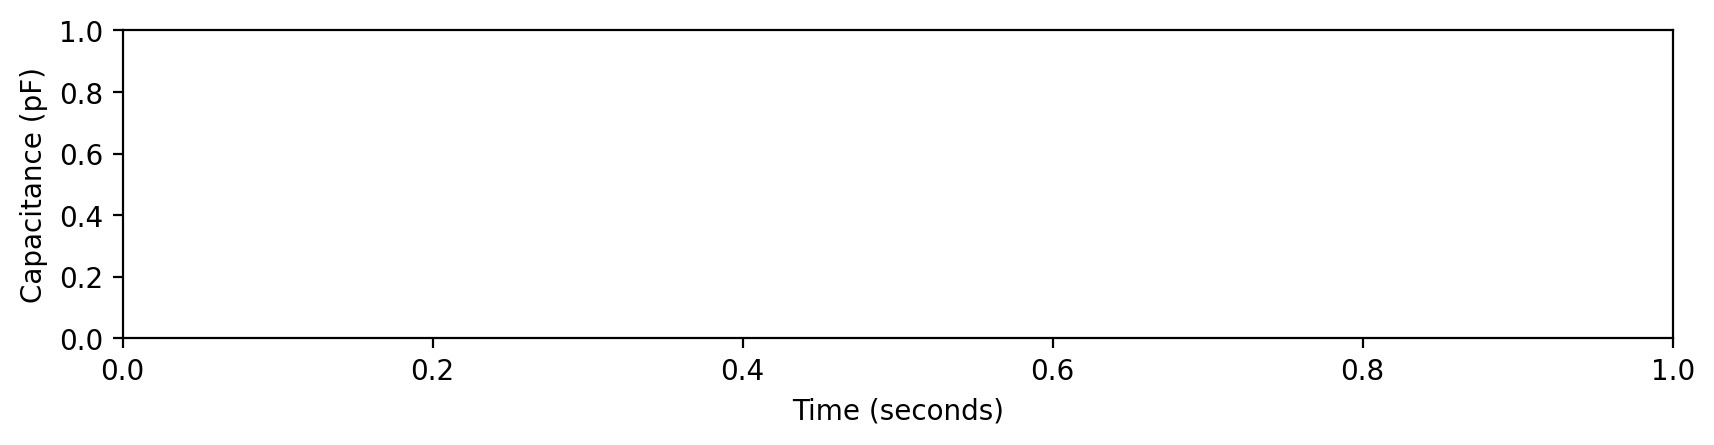

In [3]:
# Create a figure
fig, ax = pyplot.subplots(figsize=(10, 2), dpi=200) # Figure size only necessary if live plot is enabled (see below)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Capacitance (pF)")

# Preallocate array memory
array = numpy.empty((int(1e6), 2)) # Allocates array of 1,000,000 rows and 2 columns
array[:,:] = numpy.nan # Initialize all cells in the array as NaN

# Performance optimizations(?)
# pyplot.ioff()

# Collect data
try:
    idx = 0
    while True:
        # Collect data and extract values
        line = ser.readline()
        """
        print("Initializing")
        if line.decode('utf-8') == "Initializing\n": 
            print("Skipping this")
            continue
        """
        match = re_pattern.match(line.decode('utf-8'))
        print(line.decode('utf-8')) # Print out current reading from Arduino to the console. 
        try: 
            # Store data in the arrays
            array[idx, 0] = float(match.group("Time"))
            array[idx, 1] = float(match.group("Capacitance"))
            idx += 1
        except:
            continue
        # Display a live plot of the data. Currently disabled because it's extremely laggy. Maybe setup a moving window.
        """
        ax.plot(array[:, 0], array[:, 1], color="blue")
        display(fig)
        clear_output(wait=True)
        """

except KeyboardInterrupt:
    pass # expected -> what happens when you stop the cell

## Save Data

Run this after the previous block has been stopped to save all of the data collected from the previous step to a .csv.

If running for the first time, edit the path to the base folder!

In [ ]:
# Create dataframe
data_df = pandas.DataFrame(array, columns=['Time','Capacitance'])  # Name columns Time and Capacitance
data_df = data_df.dropna() # Delete all rows without data (NaN)

# Construct file name with current date and time
now_time = datetime.datetime.now().isoformat(timespec="seconds")
now_time = now_time.replace(":", "-")
data_file_name = "cap_data_" + now_time + ".csv"

# Path to base folder (Use forward slashes)
data_base_path = Path(r"C:\Users\iSenSys\Desktop\AD7746\Capacitance Results")

# Save file to path with filename
data_df.to_csv(data_base_path / data_file_name)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (622409328.py, line 11)

## Shutdown Communications

Run this at the end if done with testing or to release COM3 for another program (like Arduino IDE) to communicate with the Ardunio on it. Can also restart kernel to release COM3.

In [ ]:
ser.close()